## CurveVel-A (Fold)

## 2D foundation velocity model loading

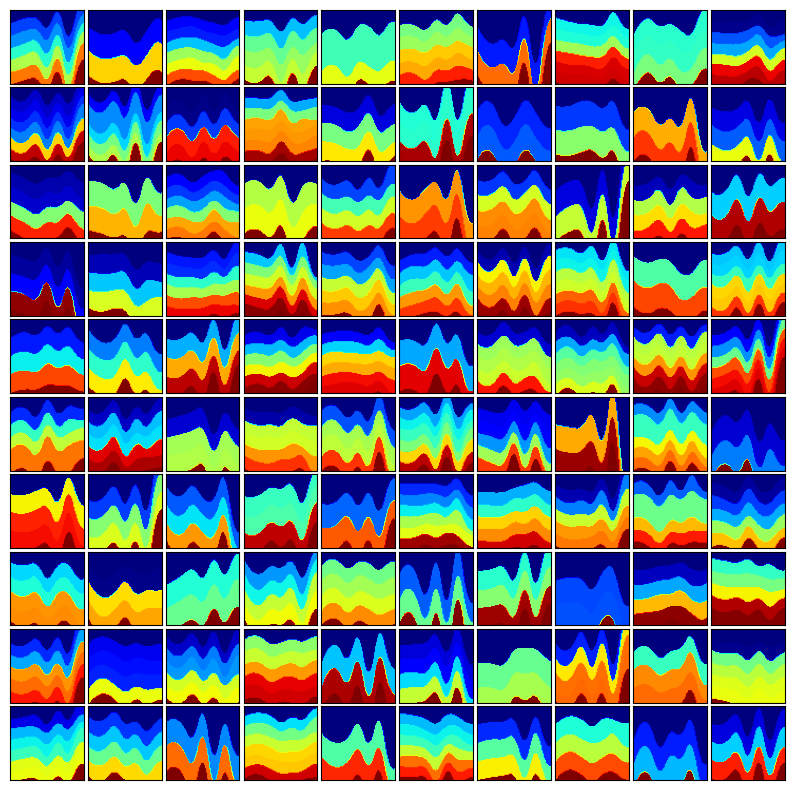

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../")
from SWIDP.process_1d_shallow import *
from SWIDP.dispersion import *
from p_tqdm import p_map


data_base_path = "../../../OpenSWI/Datasets/Original/OpenSWI-shallow/CurveVel_A/model"

models_list = os.listdir(data_base_path)


models_path_list = []
for model_name in models_list:
    model_path = os.path.join(data_base_path, model_name)
    models_path_list.append(model_path)


vel_model_subsets0 = np.load(models_path_list[10])
vel_model_subsets0 = vel_model_subsets0.squeeze()

nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(vel_model_subsets0[i*ncols+j],cmap="jet")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()


## 1D velocity model augmentation (example)

### Step 1: Velocity extraction

In [2]:
from SWIDP.dispersion import *

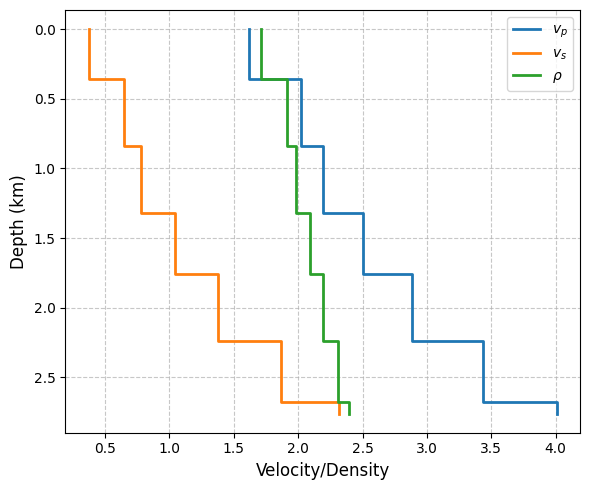

In [3]:
# extract 1 velocity profile
vp = vel_model_subsets0[0,:,10]/1000

# transform vp to vs using the empirical relation
vs = transform_vp_to_vs(vp)
depth = np.arange(len(vs))*0.04
vel_model = transform_vs_to_vel_model(vs,depth=depth)

# figure the velocity model
plt.figure(figsize=(6, 5))
plt.step(vel_model[:, 1], vel_model[:, 0], label=r"$v_p$", linewidth=2)
plt.step(vel_model[:, 2], vel_model[:, 0], label=r"$v_s$", linewidth=2) 
plt.step(vel_model[:, 3], vel_model[:, 0], label=r"$\rho$", linewidth=2)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Velocity/Density', fontsize=12)
plt.ylabel('Depth (km)', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Step 2: Velocity Augmentation

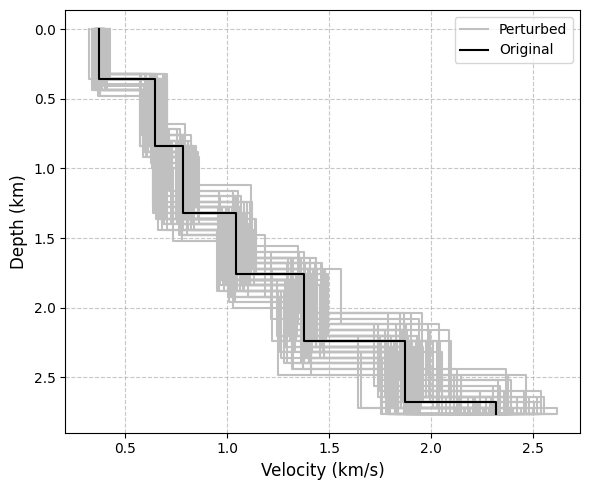

In [4]:
# get the vs model
vs = vel_model[:,2]
depth = vel_model[:,0]

# disturb the vs model
perturb_nums = 100
vs_perturbation = 0.05
thickness_perturbation = 0.1
vel_threshold = 0.1
thickness_threshold = 0.01
min_layers_num = 3
smooth_vel = False
smooth_nodes = 10

new_vs = augment_workflow(vs,
                          depth,
                          perturb_nums,
                          vs_perturbation,
                          thickness_perturbation,
                          vel_threshold,
                          thickness_threshold,
                          min_layers_num,
                          smooth_vel,
                          smooth_nodes)

# figure all the augmented vs models

plt.figure(figsize=(6,5))
for i in range(new_vs.shape[0]):
    plt.step(new_vs[i],depth,c="silver",label="Perturbed" if i == 0 else None)
plt.step(vs,depth,c="k",label="Original")
plt.gca().invert_yaxis()
plt.legend(fontsize=10)
plt.xlabel("Velocity (km/s)",fontsize=12)
plt.ylabel("Depth (km)",fontsize=12)
plt.grid(True,linestyle="--",alpha=0.7)
plt.tight_layout()
plt.show()

### Step3: Surface Wave Dispersion Curve Modeling

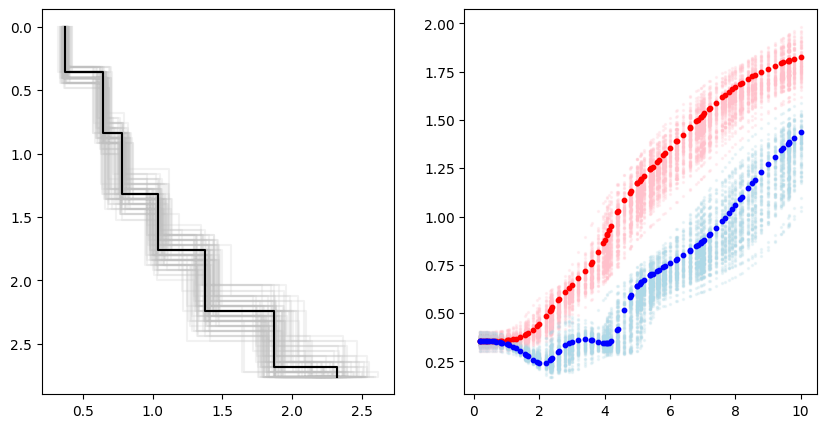

In [5]:
t = generate_mixed_samples(num_samples=100,start=0.2,end=10,uniform_num=50,log_num=20,random_num=30)

disp_original = calculate_dispersion(vel_model,t=t)
disp_augmented = []
for i in range(new_vs.shape[0]):
    new_vel_model_i = transform_vs_to_vel_model(new_vs[i],depth=depth)
    disp_augmented.append(calculate_dispersion(new_vel_model_i,t=t))
disp_augmented = np.array(disp_augmented)

plt.figure(figsize=(10,5))
plt.subplot(121)
for i in range(new_vs.shape[0]):
    plt.step(new_vs[i],depth,c='silver',label='Perturbed' if i == 0 else None, alpha=0.2)
plt.step(vel_model[:,2],depth,c='k',label='Original')
plt.gca().invert_yaxis()

plt.subplot(122)
for i in range(new_vs.shape[0]):
    plt.scatter(disp_augmented[i][:,0],disp_augmented[i][:,1],s=2,c='pink', alpha=0.2)
    plt.scatter(disp_augmented[i][:,0],disp_augmented[i][:,2],s=2,c='lightblue', alpha=0.2)
plt.scatter(disp_original[:,0],disp_original[:,1],s=10,c='r')
plt.scatter(disp_original[:,0],disp_original[:,2],s=10,c='b')
plt.show()

## 1D velocity model augmentation (multi-processing paralle)

### Step1: extract multiple 1D velocity models

  0%|          | 0/500 [00:00<?, ?it/s]

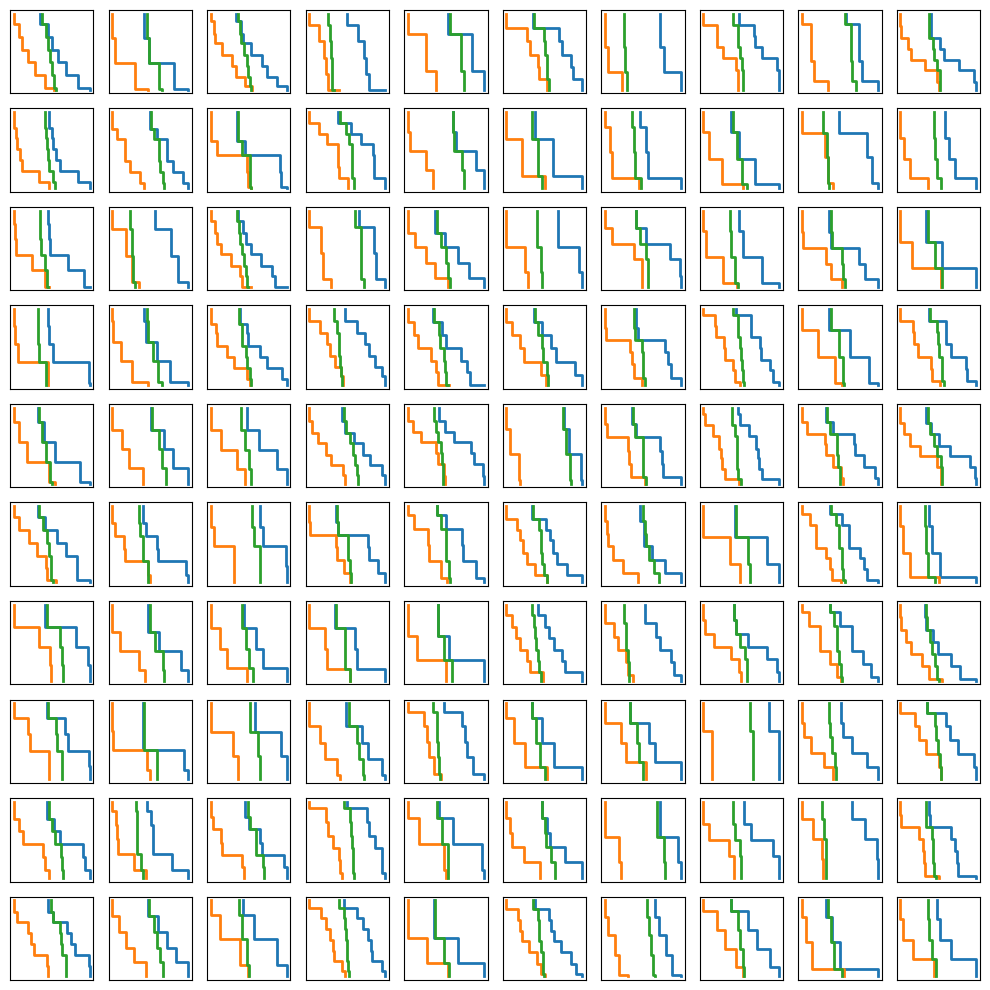

In [6]:
# extract 1 velocity profile
vp = vel_model_subsets0[:,:,10]/1000

# transform vp to vs using the empirical relation
vs = transform_vp_to_vs(vp)
depth = np.arange(vs.shape[-1])*0.04
vel_models = p_map(transform_vs_to_vel_model,list(vs),[depth]*len(vs))
vel_models = np.array(vel_models)

# figure the velocity model
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].step(vel_models[i*ncols+j][:, 1], vel_models[i*ncols+j][:, 0], label=r"$v_p$", linewidth=2)
        axs[i,j].step(vel_models[i*ncols+j][:, 2], vel_models[i*ncols+j][:, 0], label=r"$v_s$", linewidth=2) 
        axs[i,j].step(vel_models[i*ncols+j][:, 3], vel_models[i*ncols+j][:, 0], label=r"$\rho$", linewidth=2)
        axs[i,j].invert_yaxis()
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.tight_layout()
plt.show()


### Step 2: Pertubation each 1D profiles for N times

In [ ]:
# get the vs model
vs_list = vel_models[:,:,2].tolist() # (n_models, n_depth)
depth_list = vel_models[:,:,0].tolist() # (n_models, n_depth)

# disturb the vs model
perturb_nums = 100
vs_perturbation = 0.05
thickness_perturbation = 0.1
vel_threshold = 0.1
thickness_threshold = 0.01
min_layers_num = 3
smooth_vel = False
smoothnodes = 10

new_vs_list = p_map(augment_workflow,
               vs_list,
               depth_list,
               [perturb_nums]*len(vs_list),
               [vs_perturbation]*len(vs_list),
               [thickness_perturbation]*len(vs_list),
               [vel_threshold]*len(vs_list),
               [thickness_threshold]*len(vs_list),
               [min_layers_num]*len(vs_list),
               [smooth_vel]*len(vs_list),
               [smoothnodes]*len(vs_list))
new_vs_list = np.array(new_vs_list) # (n_models, n_perturbations, n_depth)


# figure all the augmented vs models
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = i*ncols+j
        for k in range(perturb_nums):
            axs[i,j].step(new_vs_list[sta_idx][k],depth_list[sta_idx],c="silver",label="Perturbed" if i == 0 else None)
        axs[i,j].step(new_vs_list[sta_idx][0],depth_list[sta_idx],c="k",label="Original")
        axs[i,j].step(new_vs_list[sta_idx][10],depth_list[sta_idx],c="r")
        axs[i,j].invert_yaxis()
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.tight_layout()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

### Step 3: Calculate the corresponding dispersion curves

In [8]:
new_vs_list = new_vs_list.reshape(-1,70)
new_depth_list = [np.arange(70)*0.04]*new_vs_list.shape[0]

# transform vs to vel model [depth,vp,vs,rho]
new_vel_models = p_map(transform_vs_to_vel_model,list(new_vs_list),new_depth_list)

# calculate the dispersion curves
new_disp_data = p_map(calculate_dispersion,new_vel_models,[t]*len(new_vel_models))

# convert the list to numpy array
new_vs_list = np.array(new_vs_list)
new_vel_models = np.array(new_vel_models)
new_disp_data = np.array(new_disp_data)

# exclude the failed models (uncomment when construct datasets)
# valid_indices = ~np.all(new_disp_data == 0, axis=(1,2))
# new_vs_list = new_vs_list[valid_indices]
# new_vel_models = new_vel_models[valid_indices]
# new_disp_data = new_disp_data[valid_indices]

new_vel_models.shape,new_disp_data.shape


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

((50000, 70, 4), (50000, 100, 3))

In [ ]:
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))

for i in range(nrows):
    for j in range(ncols//2):

        sta_idx = np.random.randint(0,vel_models.shape[0])

        # velocity profile
        for k in range(perturb_nums):
            temp_vs = new_vel_models[sta_idx*perturb_nums+k][:,2]
            temp_depth = new_vel_models[sta_idx*perturb_nums+k][:,0]
            if temp_vs.sum() == 0:
                continue
            else:
                axs[i,j*2].step(temp_vs,temp_depth,c='silver',alpha=0.2)
        axs[i,j*2].step(new_vel_models[sta_idx*perturb_nums][:,2],new_vel_models[sta_idx*perturb_nums][:,0],c='k')
        axs[i,j*2].step(new_vel_models[sta_idx*perturb_nums+10][:,2],new_vel_models[sta_idx*perturb_nums+10][:,0],c='r')
        axs[i,j*2].set_xticks([])
        axs[i,j*2].set_yticks([])
        axs[i,j*2].invert_yaxis()

        # dispersion curve
        for k in range(perturb_nums):
            temp_t = new_disp_data[sta_idx*perturb_nums+k][:,0]
            temp_phase_vel = new_disp_data[sta_idx*perturb_nums+k][:,1]
            temp_group_vel = new_disp_data[sta_idx*perturb_nums+k][:,2]
            if temp_phase_vel.sum() == 0 or temp_group_vel.sum() == 0:
                continue
            else:
                axs[i,j*2+1].scatter(temp_t,temp_phase_vel,s=0.2,c='pink', alpha=0.2)
                axs[i,j*2+1].scatter(temp_t,temp_group_vel,s=0.2,c='lightblue', alpha=0.2)
        axs[i,j*2+1].scatter(new_disp_data[sta_idx*perturb_nums][:,0],new_disp_data[sta_idx*perturb_nums][:,1],s=2,c='r')
        axs[i,j*2+1].scatter(new_disp_data[sta_idx*perturb_nums][:,0],new_disp_data[sta_idx*perturb_nums][:,2],s=2,c='b')
        axs[i,j*2+1].set_xticks([])
        axs[i,j*2+1].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

## Process All the OpenFWI-FlatVel datasets

In [ ]:
save_base_path = "../../../OpenSWI/Datasets/OpenSWI-shallow/0.2-10s-Aug/"

# Initialize empty lists to store data
disp_data_all  = []
vel_models_all = []
disturb_nums = 5
vs_perturbation = 0.05
thickness_perturbation = 0.1
vel_threshold = 0.1
thickness_threshold = 0.01
min_layers_num = 3
smooth_vel = False
smooth_nodes = 10
depth = np.arange(70)*0.04

try:
# Process each model file
    for path in models_path_list:
        # Load and preprocess velocity model
        vp_model_subset = np.load(path).squeeze()
        vp_model_subset = np.swapaxes(vp_model_subset, 1, 2)
        vp_model_subset = vp_model_subset.reshape(-1, vp_model_subset.shape[-1])[::7]/1000
        vp_model_subset = np.unique(vp_model_subset, axis=0)

        # perturb the vp model
        vp_model_subset = p_map(augment_workflow,
                                list(vp_model_subset),
                                [depth]*len(vp_model_subset),
                                [disturb_nums]*len(vp_model_subset),
                                [vs_perturbation]*len(vp_model_subset),
                                [thickness_perturbation]*len(vp_model_subset),
                                [vel_threshold]*len(vp_model_subset),
                                [thickness_threshold]*len(vp_model_subset),
                                [min_layers_num]*len(vp_model_subset),
                                [smooth_vel]*len(vp_model_subset),
                                [smooth_nodes]*len(vp_model_subset))
        
        vp_model_subset = np.array(vp_model_subset).reshape(-1,70)
        vp_model_subset = vp_model_subset[vp_model_subset.sum(axis=1) > 0]

        # transform vp to vs
        vs_models = transform_vp_to_vs(vp_model_subset)

        # transform vs to [depth,vp,vs,rho] model
        vel_models = p_map(transform_vs_to_vel_model, list(vs_models), [depth]*len(vs_models))

        # Calculate dispersion curves
        disp_data = p_map(calculate_dispersion, vel_models)
        disp_data = np.array(disp_data)
        
        # Store results
        disp_data_all.extend(disp_data)
        vel_models_all.extend(vel_models)

    # Convert lists to numpy arrays and reshape
    disp_data_all = np.array(disp_data_all)
    vel_models_all = np.array(vel_models_all)

    # Filter out zero dispersion curves and corresponding velocity models
    valid_indices  = ~np.all(disp_data_all == 0, axis=(1,2))
    disp_data_all  = disp_data_all[valid_indices]
    vel_models_all = vel_models_all[valid_indices]

    # Create output directory if it doesn't exist
    os.makedirs(save_base_path, exist_ok=True)

    # Save processed data as compressed npz files
    np.savez_compressed(os.path.join(save_base_path, "CurveVelA_model.npz"),
                       data=vel_models_all.astype(np.float32))
    np.savez_compressed(os.path.join(save_base_path, "CurveVelA_disp.npz"),
                       data=disp_data_all.astype(np.float32))
                    
except Exception as e:
    print(f"An error occurred during processing: {str(e)}")

  0%|          | 0/15803 [00:00<?, ?it/s]

  0%|          | 0/63040 [00:00<?, ?it/s]